In [95]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

![jupyter](https://nchlis.github.io/2019_10_30/architecture_unetV2.png)

In [96]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

[0 3 6]


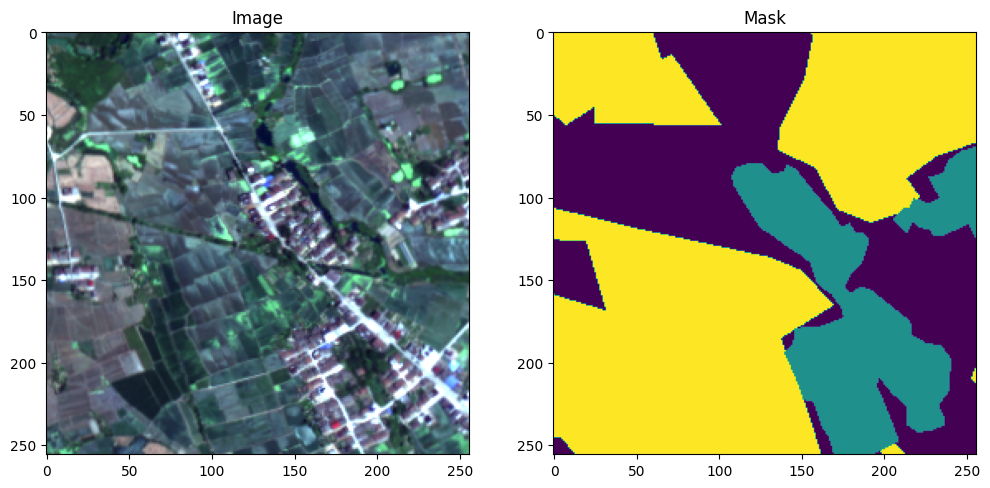

In [143]:
train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

img_list.sort()
msk_list.sort()

num_images = len(os.listdir(train_img_dir))
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='viridis')
print(np.unique(mask_for_plot))
plt.title('Mask')
plt.show()

In [110]:
seed=42
batch_size= 16
n_classes=16

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Label information of 15 classes:

* background - 0

* industrial land - 1
* urban residential - 2
* rural residential - 3
* traffic land - 4

* paddy field - 5
* irrigated land - 6
* dry cropland - 7
* garden plot - 8

* arbor woodland - 9
* shrub land - 10

* natural grassland - 11
* artificial grassland - 12

* river - 13
* lake - 14
* pond - 15

In [111]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)
    # mask[mask>13] = 13 ### water
    mask = to_categorical(mask, num_class)
    return (img, mask)

In [112]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [113]:
train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)

val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

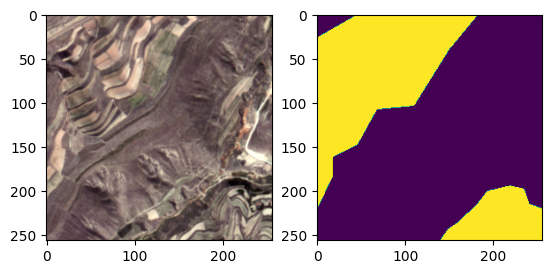

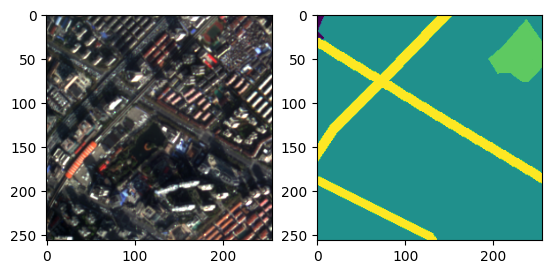

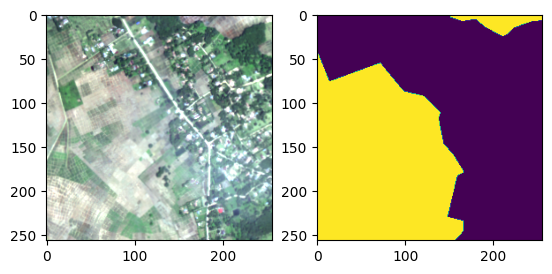

[0 6 9]


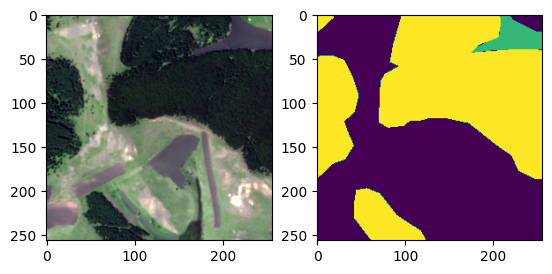

[0 1 3 9]


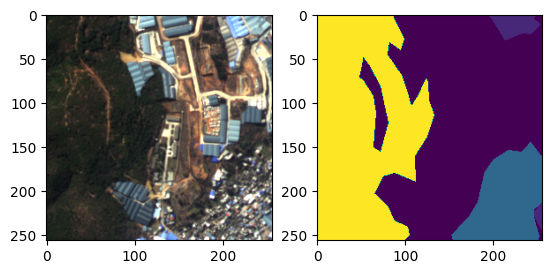

[ 0  6 13]


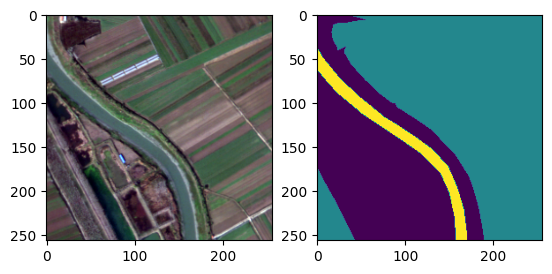

In [125]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    print(np.unique(mask))
    plt.show()

In [115]:
num_train_imgs = len(os.listdir(train_img_path+"/train"))
num_val_images = len(os.listdir(val_img_path+"/val"))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = 3

In [124]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_136 (ZeroPaddin  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                            

 zero_padding2d_142 (ZeroPaddin  (None, 66, 66, 64)  0           ['stage1_unit3_relu1[0][0]']     
 g2D)                                                                                             
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 64, 64, 64)   36864       ['zero_padding2d_142[0][0]']     
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 64, 64, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 64, 64, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
          

 zation)                                                                                          
                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 32, 32, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_149 (ZeroPaddin  (None, 34, 34, 128)  0          ['stage2_unit3_relu2[0][0]']     
 g2D)                                                                                             
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 32, 32, 128)  147456      ['zero_padding2d_149[0][0]']     
                                                                                                  
 add_69 (A

 g2D)                                                                                             
                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_155[0][0]']     
                                                                                                  
 add_72 (Add)                   (None, 16, 16, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_71[0][0]']                 
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 16, 16, 256)  1024       ['add_72[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage3_un

 zation)                                                                                          
                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 16, 16, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_162 (ZeroPaddin  (None, 18, 18, 256)  0          ['stage3_unit6_relu1[0][0]']     
 g2D)                                                                                             
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 16, 16, 256)  589824      ['zero_padding2d_162[0][0]']     
                                                                                                  
 stage3_un

 g2D)                                                                                             
                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 8, 8, 512)    2359296     ['zero_padding2d_168[0][0]']     
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 8, 8, 512)   2048        ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 8, 8, 512)   0           ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

 decoder_stage2b_conv (Conv2D)  (None, 64, 64, 64)   36864       ['decoder_stage2a_relu[0][0]']   
                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 64, 64, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 64, 64, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 128, 128, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
          

In [127]:
model.load_weights('unet_weights.h5')

In [128]:
try:
    history=model.fit(train_img_gen,
              steps_per_epoch=steps_per_epoch,
              epochs=25,
              verbose=1,
              validation_data=val_img_gen,
              validation_steps=val_steps_per_epoch)
except KeyboardInterrupt:
    pass
    #model.save_weights('unet_weights.h5')

Epoch 1/25
  16/2205 [..............................] - ETA: 6:23 - loss: 0.6149 - iou_score: 0.4266

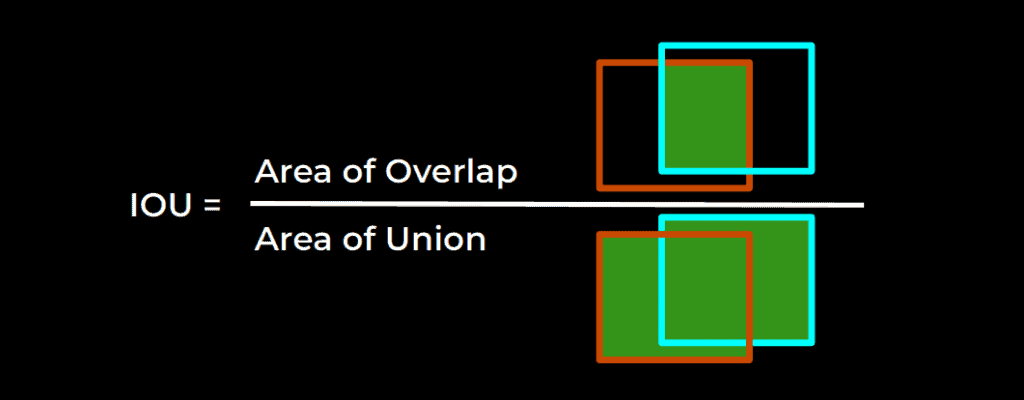

In [136]:
# model.save_weights('unet_weights.h5')

1/1 [==============================] - 0s 15ms/step
Mean IoU = 0.38203338
[0 9]
[0 9]


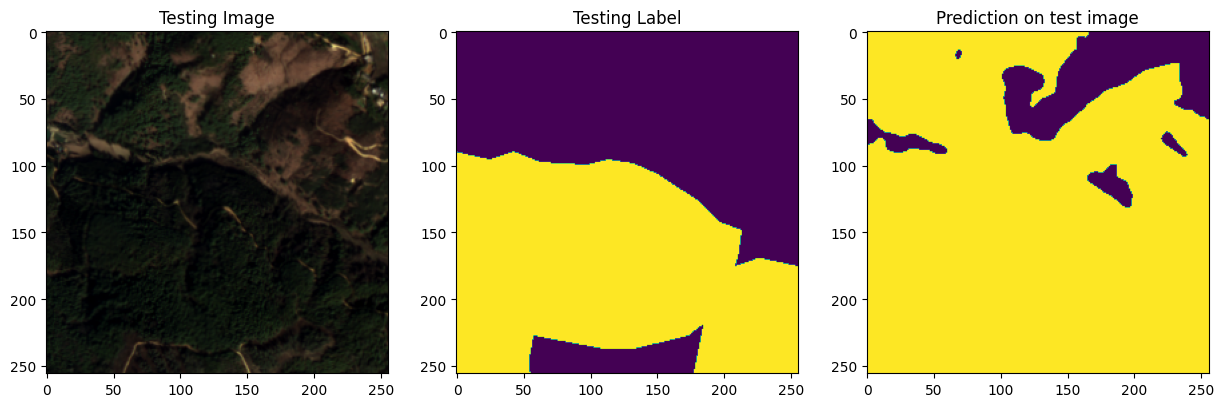

In [157]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

img_num = random.randint(0, test_image_batch.shape[0]-1)

print(np.unique(test_mask_batch_argmax[img_num]))
print(np.unique(test_pred_batch_argmax[img_num]))

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

## Label information of 15 classes:

* background - 0

* industrial land - 1
* urban residential - 2
* rural residential - 3
* traffic land - 4

* paddy field - 5
* irrigated land - 6
* dry cropland - 7
* garden plot - 8

* arbor woodland - 9
* shrub land - 10

* natural grassland - 11
* artificial grassland - 12

* river - 13
* lake - 14
* pond - 15

## Планы
- 1) построить confusion matrix
- 2) объединить классы на основании cm
- 3) другие backbone
- 4) финальная модель